In [20]:
import sys, os
tag = 1
decay = "emu"
classifiers_dir = 'classifiers/'.format(decay, tag)
if not os.path.exists(classifiers_dir):
    raise Exception("Cannot find the classifiers folder!")
    
best_classifier_name = 'xgboost'

#folder for the trained classifiers
classifiers_subdir = "/trained_"+best_classifier_name+str(tag)+"_"+decay+"/"
dir_name = classifiers_dir+classifiers_subdir
if os.path.exists(dir_name):
    raise Exception("Path exists!")
else:
    os.mkdir(dir_name)

In [21]:
#retrieve best classifier

import pickle
file_name = classifiers_dir+best_classifier_name+"_"+decay+"_"+str(tag)+".pickle.dat"
if os.path.exists(file_name):
        best_classifier = pickle.load(open(file_name, "r"))
else: raise Exception("Cannot find the classifier!")
    
#branches = best_classifier.features ##for now they are set manyally. I'll fix this later byt taking them from vars_db
branches = best_classifier.features
branches = [var.replace("_mathPLUS_", "+").replace("_mathMINUS_", "-").replace("_mathTIMES_", "*").replace("_mathOVER_", "/") for var in branches]
additional_branches = ['Lb_M', 'eventNumber'] #spectator variables and others
branches

['Lb_IPCHI2_OWNPV',
 'Lb_PT',
 'L0_ORIVX_CHI2',
 'l1_IPCHI2_OWNPV',
 'l2_IPCHI2_OWNPV',
 'Lb_HOP',
 'L0_DIRA_OWNPV',
 'Lb_ConeIsoInfoH1_CC_PTASYM',
 'Lb_ConeIsoInfoH2_CC_PTASYM',
 'Lb_ConeIsoInfoL1_CC_PTASYM',
 'Lb_ConeIsoInfoL2_CC_PTASYM',
 'Lb_TrackIsoInfoH1_CONEMULT',
 'Lb_TrackIsoInfoH2_CONEMULT',
 'Lb_TrackIsoInfoL1_CONEMULT',
 'Lb_TrackIsoInfoL2_CONEMULT']

In [22]:
 #get kerberos token for eos
import getpass
os.system("echo %s | kinit gandreas@CERN.CH" %getpass.getpass()) 

········


0

Password for gandreas@CERN.CH: 


In [23]:
#load data

#first, the trainig data:
import ROOT
import cuts
import pandas as pd
import numpy as np

MC_tree = ROOT.TChain('Lb2LemuTuple/DecayTree')
MC_tree.Add(os.getenv("GUIDOANAEOSLOC")+"tuples/S28/MC/Lb_Lemu_MC_2016_M*.root")

data_tree = ROOT.TChain('Lb2LemuTuple/DecayTree')
#temporary fix:
from glob import glob

for file in glob(os.getenv("LBMICKJOBLOC")+"209/[0-2][0-5]/DVNtuple.root"):
    data_tree.AddFile(file)
for file in glob(os.getenv("LBMICKJOBLOC")+"210/[0-2][0-5]/DVNtuple.root"):
    data_tree.AddFile(file)

    
    
from tools.convert_data import convert_data
import root_numpy
import imp
import sys
imp.reload (sys.modules['tools.convert_data'])


signal_training_cut = cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run1_full

#print signal_training_cut.GetTitle()
train_data, train_labels, test_data, test_labels = convert_data (MC_tree,
                                                                 (cuts.Lb_Lemu_preselection+cuts.Lb_Lemu_matching+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training).GetTitle(),
                                                                 data_tree,
                                                                 (cuts.Lb_Lemu_preselection+cuts.Lb_Lemu_sidebands+cuts.Lb_Lemu_trigger_run2_full_for_MVA_training).GetTitle(),
                                                                 branches+additional_branches,
                                                                 test_frac = 0.2)


#let's also prepare signal and background in separate dataframes for convenience
train_data_with_labels = pd.DataFrame(np.hstack((train_data, train_labels.reshape(train_labels.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])
test_data_with_labels = pd.DataFrame(np.hstack((test_data, test_labels.reshape(test_labels.shape[0], -1))),
                  columns=branches+additional_branches+['labels'])

train_data_signal_with_labels = train_data_with_labels.loc[train_data_with_labels['labels']>0.5]
train_data_background_with_labels = train_data_with_labels.loc[train_data_with_labels['labels']<0.5]
test_data_signal_with_labels = test_data_with_labels.loc[test_data_with_labels['labels']>0.5]
test_data_background_with_labels = test_data_with_labels.loc[test_data_with_labels['labels']<0.5]


MC_data = root_numpy.tree2array(tree=MC_tree, branches=branches+additional_branches)
MC_data=pd.DataFrame(MC_data)

In [24]:
#now we have to change names to the input variables removing the mathematical symbols, otherwise tmva gets confused
#I'm actually not using a TMVA classifier here now, but better keep the compatibility for the future...
train_data_with_labels.columns = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in train_data_with_labels.columns]
test_data_with_labels.columns = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in test_data_with_labels.columns]

In [25]:
#we will define the k samples of the k-folding using the modulo k of the eventNumber
k = 5
training_folds = []

for i in range(k):
    training_folds.append(train_data_with_labels.loc[train_data_with_labels['eventNumber']%k==i])

In [26]:
# X-checking
tot = train_data_with_labels.shape[0]

for i in range(k):
    tot = tot-training_folds[i].shape[0]
if (tot!=0):
    raise Exception("Something went wrong in the splitting in k-folds!!")

In [27]:
#Now let's train

from sklearn.base import clone
k_classifiers=[]
for i in range(k):
    print "Training fold", i, "..."
    this_classifier = clone(best_classifier)
    these_training_data = pd.concat([training_folds[j] for j in range(k) if j is not i], axis=0)
    this_classifier.fit(these_training_data, these_training_data['labels'])
    k_classifiers.append(this_classifier)
print "Done!"

#and save them to file
import pickle

j=0
for classifier in k_classifiers:
    file_name = classifiers_dir+best_classifier_name+"_"+decay+"_"+str(tag)+"k"+str(j)+"_trained.pickle.dat"
    if os.path.exists(file_name):
        os.remove(file_name)
    pickle.dump(classifier, open(file_name, "wb"))
    j=j+1

Training fold 0 ...
Training fold 1 ...
Training fold 2 ...
Training fold 3 ...
Training fold 4 ...
Done!


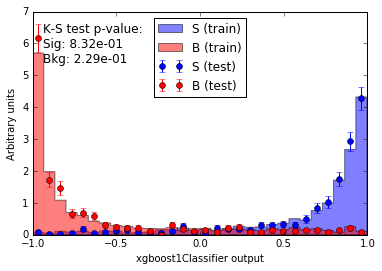

[Ks_2sampResult(statistic=0.031622312065116565, pvalue=0.83186043998210402),
 Ks_2sampResult(statistic=0.057039901435050333, pvalue=0.22906675567593776)]

Applying MVA to fold 0 ...
Applying MVA to fold 1 ...
Applying MVA to fold 2 ...
Applying MVA to fold 3 ...
Applying MVA to fold 4 ...
Done!
Applying MVA to fold 0 ...
Applying MVA to fold 1 ...
Applying MVA to fold 2 ...
Applying MVA to fold 3 ...
Applying MVA to fold 4 ...
Done!
Applying MVA to fold 0 ...
Applying MVA to fold 1 ...
Applying MVA to fold 2 ...
Applying MVA to fold 3 ...
Applying MVA to fold 4 ...
Done!
Applying MVA to fold 0 ...
Applying MVA to fold 1 ...
Applying MVA to fold 2 ...
Applying MVA to fold 3 ...
Applying MVA to fold 4 ...
Done!


In [42]:
#overtraining check
import imp
import sys
import matplotlib.pyplot as plt
from tools.compare_train_test import compare_train_test
imp.reload (sys.modules['tools.compare_train_test'])
from tools.compare_train_test import compare_train_test
%matplotlib inline
plt.close('all')
compare_train_test(k_classifiers, "xgboost1",
                   train_data_signal_with_labels,
                   train_data_background_with_labels,
                  test_data_signal_with_labels,
                  test_data_background_with_labels, 30, True,
                  dir_name+best_classifier_name+"overtraining_plot.pdf")

In [10]:
i=0
for classifier in k_classifiers:
    file_name = dir_name+best_classifier_name+"_k"+str(i)+".pickle.dat"  
    pickle.dump(classifier, open(file_name, "wb"))
    i = i+1

In [11]:
#now we apply the MVA to the testing data, and we save them to use later for the cut optimisation
from tools.applyMVA import applyMVA
test_data_with_pred=applyMVA(k_classifiers, best_classifier_name+str(tag),test_data_with_labels)
#save test data, for the ROC
test_data_with_pred.to_csv(dir_name+"test_data_with_labels_with_pred_"+decay+".csv")

Applying MVA to fold 0 ...
Applying MVA to fold 1 ...
Applying MVA to fold 2 ...
Applying MVA to fold 3 ...
Applying MVA to fold 4 ...
Done!


In [ ]:
### the code below is already implemented elsewhere. I think I should remove it from here

In [ ]:
import sys, os
tag = 0
decay = "emu"
classifiers_dir = 'classifiers/'.format(decay, tag)
if not os.path.exists(classifiers_dir):
    raise Exception("Cannot find the classifiers folder!")
    
best_classifier_name = 'xgboost'

In [ ]:
#then, all the rest of the OS. This is going to take a lot of time

#split input files in chunks

l = glob(os.getenv("LBMICKJOBLOC")+"209/*/DVNtuple.root")
l.extend(glob(os.getenv("LBMICKJOBLOC")+"210/*/DVNtuple.root"))
lofl=[]
all_data_tree=[]
bkg_data=[]
n=50
for i in range(0, len(l), n):
    these_files = l[i:i+n]
    all_data_tree.append(ROOT.TChain('Lb2LemuTuple/DecayTree'))
    for file in these_files:
        all_data_tree[-1].AddFile(file)
    these_bkg_data = root_numpy.tree2array(tree=all_data_tree[0], branches=branches+additional_branches)
    bkg_data.append(pd.DataFrame(these_bkg_data))

In [ ]:
#now we have to change names to the input variables removing the mathematical symbols, otherwise tmva gets confused
#I'm actually not using a TMVA classifier here now, but better keep the compatibility for the future...

for these_bkg_data in bkg_data:
    these_bkg_data.columns = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in these_bkg_data.columns]

In [ ]:
from tools.applyMVA import applyMVA
from rootpy.io import root_open
imp.reload (sys.modules['tools.applyMVA'])


for i in range (len(bkg_data)):
    print "Processing chunk", i, "of", len(bkg_data), "..."
    data_with_pred=applyMVA(k_classifiers, best_classifier_name+str(tag),bkg_data[i])
    mva_column=data_with_pred[best_classifier_name+str(tag)].as_matrix().copy() 
    mva_column.dtype=[(best_classifier_name+str(tag), '<f8')]
    data_tree_clone = all_data_tree[i].CloneTree(-1)
    with root_open(os.getenv("GUIDOANAEOSLOC")+"tuples/S28/LbLemu_2016_BDT_{0}.root".format(i), mode='RECREATE') as myfile:
        t = root_numpy.array2tree(mva_column, tree=data_tree_clone)
        t.Write("",t.kWriteDelete);
        print "Writing output file with the following content: "
        myfile.ls()
        myfile.write()
    del data_with_pred
    del mva_column
    del data_tree_clone

In [ ]:
mva_column=data_with_pred[best_classifier_name+str(tag)].as_matrix().copy() 
mva_column.dtype=[(best_classifier_name+str(tag), '<f8')]
#mva_column.dtype=np.dtype(u'something')

In [ ]:
#now MC

#add predictions to each single fold

MC_data.columns = [var.replace("+","_mathPLUS_").replace("-","_mathMINUS_").replace("*","_mathTIMES_").replace("/","_mathOVER_") for var in train_data.columns]
folds_MC = []

for i in range(k):
    folds_MC.append(MC_data.loc[MC_data['eventNumber']%k==i])
    
    
#fill array with predictions
outputs_MC = []
for i in range(k):
    print "Applying MVA to fold", i , "..."
    predicted_prob = k_classifiers[i].predict_proba(folds_MC[i])
    outputs_MC.append(([a[1]-a[0] for a in predicted_prob]))
print "Done!"

folds_MC_with_pred = []
for i in range(k):
    this = folds_MC[i]
    this[best_classifier_name+str(tag)] = pd.Series(outputs_MC[i], index = this.index)
    folds_MC_with_pred.append(this)
MC_with_pred = pd.concat(folds_MC_with_pred)
MC_with_pred=MC_with_pred.sort_index()
MC_mva_column=MC_with_pred[best_classifier_name+str(tag)].as_matrix().copy() #the copy is necessary as this has to be a separate object in memory, since we want to modify it (next line)
MC_mva_column.dtype=[(best_classifier_name+str(tag), '<f8')]

from rootpy.io import root_open

MC_tree_all_clone = MC_tree.CloneTree(-1)
with root_open(os.getenv("GUIDOANAEOSLOC")+"tuples/S28/LbLemu_MC_2016_BDT.root", mode='RECREATE') as myfile:
    t = root_numpy.array2tree(MC_mva_column, tree=MC_tree_all_clone)
    t.Write("",t.kWriteDelete);
    print "Writing output file with the following content: "
    myfile.ls()
    myfile.write()

In [1]:
?MC_with_pred

Object `MC_with_pred` not found.
